# Set up

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod')) # <--- Ändra här

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SAFAD_interface import SAFAD_interface

In [3]:
# Create session object
session = cm.Session(
    name = 'SLV_v2',
    data_path = '../CIBUSmod/data',
    data_path_output = 'output',
    data_path_scenarios = 'scenarios'
)

SCN_NAME = 'SLV' # <--- Ändra här
BL_SCN = ('SLV','1')

In [4]:
def scn_tuple(y, long=False):
    pos_1 = {'1':'5%', '2':'30%'}
    pos_2 = {'1':'CMS','2':'SE','3':'SE-all'}
    pos_3 = {'1':'C','2':'PB'}
    pos_4 = {'0':'', '1':'+AP'}
    if long:
        pos_2 = {'1':'Current market shares','2':'Swedish','3':'Swedish (all consumers)'}
        pos_3 = {'1':'Chicken','2':'Plant-based'}
        pos_4 = {'0':'','1':' + Agricultural policy'}
    
    if y == '0':
        return ('BL','2016-2020','')
    if y == '1':
        return ('BL','2023','')
    else:
        return (pos_1[y[0]], pos_2[y[1]]+pos_4[y[3]], pos_3[y[2]], )
        
def make_scn_idx(idx):

    return pd.MultiIndex.from_tuples(
        [scn_tuple(y) for y in idx.get_level_values('year')],
        names = ['Compliance', 'Origin, meat', 'Substitute']
    )

CO2e_method = 'GWP100 AR6'

bar_style = {
    'cmap':'Accent',
    'group_levels':['Compliance','Substitute'],
    'grouplabels_fontsize':9,
    'ticklabels_fontsize':9,
    'grouptitle_fontsize':10,
    'ylabel_fontsize':10,
    'xlabel_fontsize':10,
    'xlabel':'Origion of red meat',
    'grouptitle':'Compliance and substitute',
}

bar_style2 = {k:v for k,v in bar_style.items() if k != 'cmap'}

def style_bar(ax, d):
    if isinstance(d, pd.DataFrame):
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1,1), frameon=False
        )
    ax.axhline(d.loc[scn_tuple(BL_SCN[1])].sum(), color='black', linestyle='--', linewidth=0.5)

def annotate_axs(axs, size=10, pos=(-0.2,1.3)):
    import string
    for i, ax in enumerate(axs.flatten()):
        ax.text(*pos, string.ascii_lowercase[i % 26],
                transform=ax.transAxes, fontsize=size,
                fontweight='bold', va='top', ha='right')

In [5]:
session.cache.clear()

# Calculate impacts from changed imports

In [6]:
SAFAD = SAFAD_interface('SAFAD_data')
SAFAD_sens = SAFAD_interface('SAFAD_data')
SAFAD.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_add_BR.csv') # <-- Add data from Brazil (also used for Argentina)
SAFAD_sens.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_sens.csv') # <-- Sensitivity analysis only Irish suckler cows for beef imports (Moberg)

to_SAFAD_codes = {
    'food' : pd.read_csv('food_to_SAFAD_codes.csv', index_col='food')['code'].dropna().to_dict(),
    'by_prod' : pd.read_csv('by_prod_to_SAFAD_codes.csv', index_col='by_prod')['code'].dropna().to_dict(),
    'crop_prod' : pd.read_csv('crop_prod_to_SAFAD_codes.csv', index_col='crop_prod')['code'].dropna().to_dict()
}

def get_ghg(SAFAD, df, CO2eq):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_GHG(to_SAFAD_codes[item][col], CO2eq=CO2eq)}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

def get_footprint(SAFAD, df, footprint):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_footprints(to_SAFAD_codes[item][col]).loc[footprint]}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

In [7]:
food_dict = {
    'Bovine meat and products' : '$\Delta$ red meat imports',
    'Broad beans and horse beans, dry' : '$\Delta$ substitute imports',
    'Mutton/goat meat' : '$\Delta$ red meat imports',
    'Peas, dry' : '$\Delta$ substitute imports',
    'Pig meat and products' : '$\Delta$ red meat imports',
    'Poultry meat and products' : '$\Delta$ substitute imports',
    'Rape and mustard oil and products' : '$\Delta$ substitute imports'
}

# Get food imports
food_import = session.get_attr('d','food_demand_to_processing',['origin','food']).loc[:,'imported']
# Calculate change from baseline and drop all foods with no change
food_import_chg = food_import.sub(food_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
food_import_chg.loc[food_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

# Adjust to align conversion factors CW --> BFM
# Clune et al (2017) are used in SAFAD data
food_import_chg.loc[:,'Bovine meat and products'] *= (0.695/0.75)
food_import_chg.loc[:,'Mutton/goat meat'] *= (0.66/0.69)
food_import_chg.loc[:,'Pig meat and products'] *= (0.59/0.71)
food_import_chg.loc[:,'Poultry meat and products'] *= (0.77/0.87)

food_import_CO2e_details = get_ghg(SAFAD, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_details_sens = get_ghg(SAFAD_sens, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e = food_import_CO2e_details.rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_excl_LUC = food_import_CO2e_details.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_excl_LUC_sens = food_import_CO2e_details_sens.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_GHG = get_ghg(SAFAD, food_import_chg, CO2eq=False).rename(columns=food_dict).T.groupby(['food','compound']).sum().T
food_import_land = get_footprint(SAFAD, food_import_chg, 'Land').rename(columns=food_dict).T.groupby('food').sum().T / 10_000
food_import_ammonia = get_footprint(SAFAD, food_import_chg, 'Ammonia').rename(columns=food_dict).T.groupby('food').sum().T

In [8]:
# Get by-product imports
byprod_import = session.get_attr('d','by_products',['origin','by_prod']).loc[:,'imported']
# Get by-product exports
byprod_export = session.get_attr('d','by_prod_demand',['demand','by_prod']).loc[:,'export']
# Calculate net imports
byprod_import = byprod_import.sub(byprod_export, fill_value=0)
# Calculate change from baseline and drop all by-products with no change
byprod_import_chg = byprod_import.sub(byprod_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
byprod_import_chg.loc[byprod_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

byprod_import_CO2e = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_CO2e_excl_LUC = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_land = get_footprint(SAFAD, byprod_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
byprod_import_ammonia = get_footprint(SAFAD, byprod_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

# Get feed imports
feed_import = session.get_attr('a','feed.crop_product_demand',['origin','crop_prod']).loc[:,'imported']
# Calculate change from baseline and drop all by-products with no change
feed_import_chg = feed_import.sub(feed_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
feed_import_chg.loc[feed_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

feed_import_CO2e = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_CO2e_excl_LUC = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_land = get_footprint(SAFAD, feed_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
feed_import_ammonia = get_footprint(SAFAD, feed_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

feed_import_CO2e += byprod_import_CO2e
feed_import_CO2e_excl_LUC += byprod_import_CO2e_excl_LUC
feed_import_land += byprod_import_land
feed_import_ammonia += byprod_import_ammonia

# Calculate impacts from LUC in Sweden

In [9]:
# Emission factors for LUC derived from Sweden's national inventory reports
# Averaged over 10 year (2013-2022). kg CO2 per ha
EF_cropland_to_forest = -1779
EF_grassland_to_forest = -1399
EF_forest_to_cropland = 7605
EF_forest_to_grassland = 9287
# Amortization period for LUC emissions, same as in Pendrill et al. (2019)
# "Agricultural and forestry trade drives large share of tropical deforestation emissions"
amort_period = 10

EF = pd.Series({
    'cropland':EF_forest_to_cropland,
    'semi-natural grasslands':EF_forest_to_grassland
})

swe_LUC = (
    session.get_attr('c','area',{'crop':'land_use'})
    .pipe(lambda df: df - df.loc[BL_SCN])
    .mul(EF, axis=1)
    .div(amort_period)
    .sum(axis=1)
    .rename('land use change (SE)')
)

# Cropland use

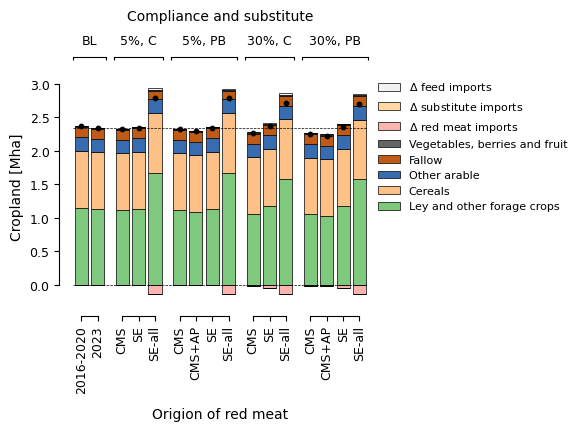

In [10]:
from matplotlib.colors import ListedColormap
colors = [plt.colormaps['Accent'](i/4) for i in range(5)]\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    session.get_attr('c','area',{'crop':['land_use','crop_group2']})
    .loc[:,'cropland']
    .sort_values(axis=1, by=('SLV','0'), ascending=False)
    .rename(columns={'Fodder crops':'Ley and other forage crops'})
    .join(food_import_land)
    .join(feed_import_land)
) / 1_000_000
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Cropland [Mha]',
    ylim=(-0.25,3.2),
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2
)
style_bar(ax, d)
plt.show()

t = d.iloc[:,0:5].sum(axis=1)
t = (t-t.loc[scn_tuple(BL_SCN[1])]) / t.iloc[0] * 100
display(t.to_frame().style.format(precision=1))

t = d.iloc[:,0:5].sum(axis=1)
display(t.to_frame().style.format(precision=1))

In [11]:
session.get_attr('c','area','crop').loc[:,'Fallow']/1_000

scn  year
SLV  0       151.693265
     1       151.697888
     1110    151.701906
     1120    151.700853
     1121    151.703877
     1210    151.700148
     1220    151.699119
     1310    128.203632
     1320    128.226522
     2110    151.722211
     2120    151.734609
     2121    151.737908
     2210    151.714482
     2220    151.725952
     2310    145.888879
     2320    145.903428
Name: Fallow, dtype: float64

In [12]:
session.get_attr('c','area','crop').loc[:,'Ley not harvested']/1_000

scn  year
SLV  0       50.615257
     1       50.615764
     1110    50.616199
     1120    50.616080
     1121    50.616424
     1210    50.615996
     1220    50.615879
     1310    41.010866
     1320    41.018671
     2110    50.618473
     2120    50.622192
     2121    50.622751
     2210    50.617476
     2220    50.620920
     2310    47.713452
     2320    47.736789
Name: Ley not harvested, dtype: float64

# Semi-natural grasslands

In [13]:
session.cache.clear()

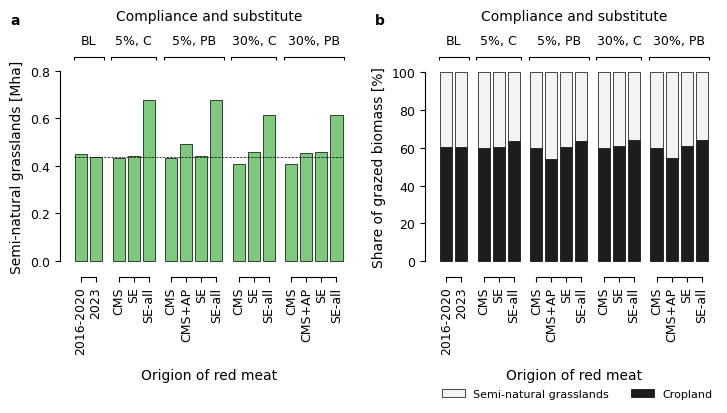

land_use                             Cropland  Semi-natural grasslands
Compliance Origin, meat Substitute                                    
BL         2016-2020                60.509355                39.490645
           2023                     60.300429                39.699571
5%         CMS          C           60.188462                39.811538
                        PB          60.188382                39.811618
           CMS+AP       PB          54.098063                45.901937
           SE           C           60.379498                39.620502
                        PB          60.379426                39.620574
           SE-all       C           63.459170                36.540830
                        PB          63.462664                36.537336
30%        CMS          C           59.755031                40.244969
                        PB          59.757112                40.242888
           CMS+AP       PB          54.425857                45.574143
           SE           C           60.975237                39.024763
                        PB          60.977460                39.022540
           SE-all       C           64.324893                35.675107
                        PB          64.334651                35.665349

In [14]:
fig,axs = plt.subplots(1,2, figsize=(8.2,2.5), gridspec_kw={'wspace':0.35})

d1 = (
    session.get_attr('c','area',{'crop':['land_use']})
    .loc[:,'semi-natural grasslands']
) / 1_000_000
d1.index = make_scn_idx(d1.index)
ax = axs[0]
ax, axgs = cm.plot.bar(
    d1,
    ax = ax,
    ylabel='Semi-natural grasslands [Mha]',
    **bar_style,
    ylim=(-0.01,0.8)
)
style_bar(ax, d1)

d2 = (
    session.get_attr('c','production',{'crop_prod':None, 'crop':'land_use'})
    .loc[:,'grazing']
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d2.index = make_scn_idx(d2.index)

ax = axs[1]
cm.plot.bar(
    d2,
    ax = ax,
    ylabel='Share of grazed biomass [%]',
    cmap='Greys',
    **bar_style2,
)
ax.legend(
    ncol=2, fontsize=8, reverse=True,
    bbox_to_anchor=(1.05,-0.6), frameon=False
)

annotate_axs(axs)

plt.show()
t = (d1-d1.loc[scn_tuple(BL_SCN[1])]).div(d1.loc[scn_tuple(BL_SCN[1])]).mul(100)
display(t.to_frame().style.format(precision=1))

display(d2)

In [15]:
a = np.array([1,2,3])

In [16]:
a.flatten()

array([1, 2, 3])

# Animal numbers

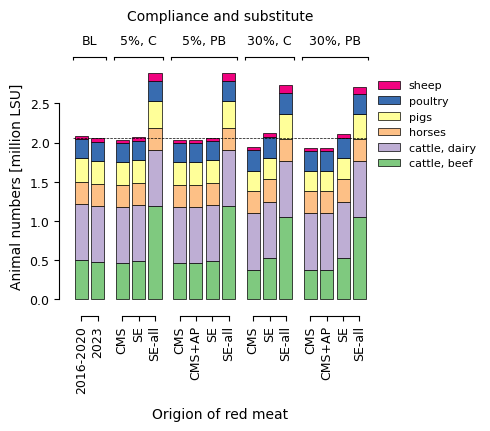

In [17]:
d = cm.impact.get_LSU(session, ['species','breed']) / 1_000_000
d.columns = pd.Index([sp if sp not in ['cattle'] else ', '.join([sp,br]) for sp,br in d.columns], name='type')
d = d.T.groupby('type').sum().T
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Animal numbers [million LSU]',
    **bar_style
)
style_bar(ax, d)
plt.show()

In [18]:
display((d-d.loc[scn_tuple(BL_SCN[1])]).div(d.loc[scn_tuple(BL_SCN[1])], axis=1).mul(100).style.format(precision=1))

In [19]:
d = session.get_attr('g','x_animals',['species','sub_system']).loc[:,'sheep']

display(100-d.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)['other sheep'])
d.drop('other sheep', axis=1)\
.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)\
.pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))

scn  year
SLV  0       63.041491
     1       60.095250
     1110    59.698202
     1120    59.698202
     1121    59.697249
     1210    61.599966
     1220    61.599966
     1310    83.308400
     1320    83.308400
     2110    57.547008
     2120    57.547008
     2121    57.548804
     2210    67.575008
     2220    67.575008
     2310    82.093967
     2320    82.093967
Name: other sheep, dtype: float64

sub_system  autumn lamb  spring lamb  winter lamb
scn year                                         
SLV 0         -0.175490     0.097796     0.077694
    1          0.000000     0.000000     0.000000
    1110      -0.339600     0.189251     0.150349
    1120      -0.339600     0.189251     0.150349
    1121      -0.340421     0.189708     0.150713
    1210      -0.325784     0.181551     0.144233
    1220      -0.325784     0.181552     0.144233
    1310       2.952134    -0.150359    -2.801775
    1320       2.952134    -0.150359    -2.801775
    2110      -0.577177     0.321647     0.255530
    2120      -0.577177     0.321647     0.255530
    2121      -0.575566     0.320749     0.254817
    2210       2.825307    -0.219537    -2.605770
    2220       2.825307    -0.219537    -2.605770
    2310       2.915819    -0.170167    -2.745652
    2320       2.915819    -0.170167    -2.745652

# Climate impact

Default


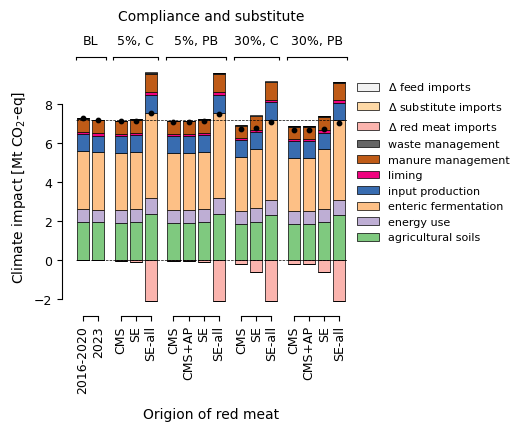

Incl. LUC


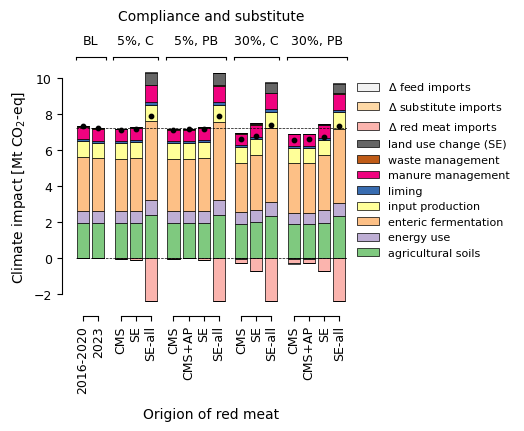

Only Irish suckler cows


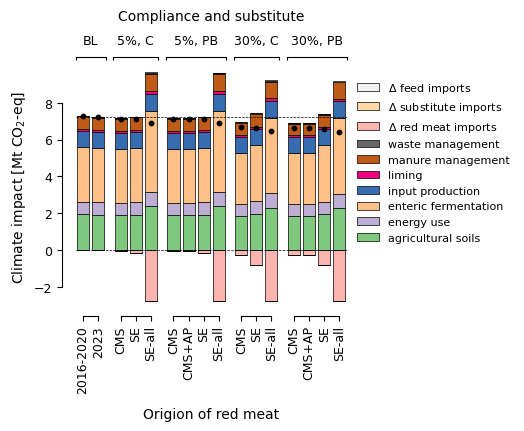

In [20]:
from matplotlib.colors import ListedColormap

d = (
    cm.impact.get_GHG(session, CO2eq=CO2e_method)
    .drop('organic soils', level='sub-process', axis=1)
    
    .T.groupby('process').sum().T
    .rename(columns={'waste and circularity':'waste management'})
) / 1_000_000_000
d1 = (
    d
    .join(food_import_CO2e_excl_LUC / 1_000_000_000)
    .join(feed_import_CO2e_excl_LUC / 1_000_000_000)
)
d2 = (
    d
    .join(swe_LUC / 1_000_000_000)
    .join(food_import_CO2e / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
)
d3 = (
    d
    .join(food_import_CO2e_excl_LUC_sens / 1_000_000_000)
    .join(feed_import_CO2e_excl_LUC / 1_000_000_000)
) 

d1.set_index(make_scn_idx(d1.index), inplace=True)
d2.set_index(make_scn_idx(d2.index), inplace=True)
d3.set_index(make_scn_idx(d3.index), inplace=True)

for dx in [d1,d2,d3]:

    if dx is d1:
        print('Default')
    if dx is d2:
        print('Incl. LUC')
    if dx is d3:
        print('Only Irish suckler cows')
    len(dx.columns) - 3
    colors = [plt.colormaps['Accent'](i/(len(dx.columns)-3-1)) for i in range(len(dx.columns)-3)]\
        + [plt.colormaps['Pastel1'](i/2) for i in range(3)]
    
    fig,ax = plt.subplots(figsize=(3.5,3))
    ax,axgs = cm.plot.bar(
        dx,
        ax=ax,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel='Climate impact [Mt CO$_2$-eq]',
        **bar_style2
    )
    style_bar(ax, dx)
    plt.show()
    
    display((
        dx
        .sum(axis=1)
        / dx.iloc[0].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

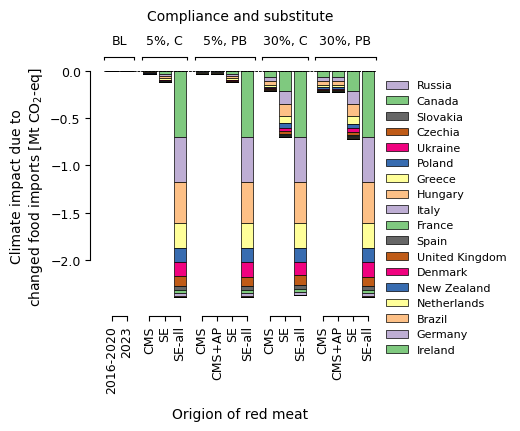

In [21]:
d = (
    food_import_CO2e_details
    .T.groupby('country').sum().T
) / 1_000_000_000
d.set_index(make_scn_idx(d.index), inplace=True)
d

fig,ax = plt.subplots(figsize=(3.5,3))
ax,axgs = cm.plot.bar(
    d,
    ax=ax,
    sort_categories=True,
    ylabel='Climate impact due to\nchanged food imports [Mt CO$_2$-eq]',
    totmarker='none',
    **bar_style
)
style_bar(ax, d)
plt.show()

# Ammonia

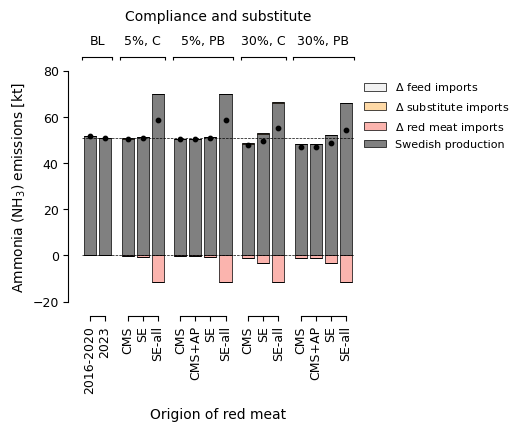

In [22]:
from matplotlib.colors import ListedColormap
colors = ['grey']\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    cm.impact.get_emissions(session)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'waste and circularity':'waste management'})
    .T.groupby('compound').sum().loc['NH3-N'].T
    .mul((14+3)/14)
    .rename('Swedish production').to_frame()
    .join(food_import_ammonia)
    .join(feed_import_ammonia)
     / 1_000_000
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Ammonia (NH$_3$) emissions [kt]',
    cmap=ListedColormap(name='X', colors=colors),
    ylim = (-20,80),
    **bar_style2
)

style_bar(ax, d)

plt.show()

# Fertilisers

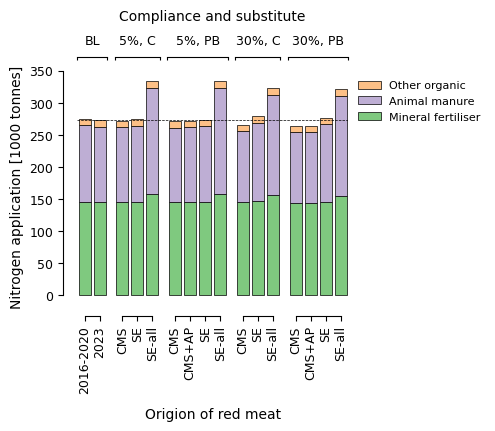

In [23]:
d = pd.concat([
    session.get_attr('c','fertiliser.mineral_N','none').rename('Mineral fertiliser'),
    session.get_attr('c','fertiliser.manure_N','none').rename('Animal manure'),
    session.get_attr('c','fertiliser.organic_N','none').rename('Other organic')
], axis=1) / 1_000_000
d.index = make_scn_idx(d.index)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Nitrogen application [1000 tonnes]',
    ylim=(-10,350),
    **bar_style
)

style_bar(ax, d)

plt.show()

# Maps

In [24]:
def rescale_colormap(cmap, min_val=0.0, max_val=1.0):
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    return colors.LinearSegmentedColormap.from_list(
        "new_cmap", cmap(np.linspace(min_val, max_val, 256))
    )

map_style1 = {
    'cmap' : 'BrBG',
    'edgecolor' : 'grey'
}
map_style2 = {
    'cmap' : rescale_colormap('BrBG',0.5,1),
    'edgecolor' : 'grey'
}



## Total Cropland and Semi-natural grasslands

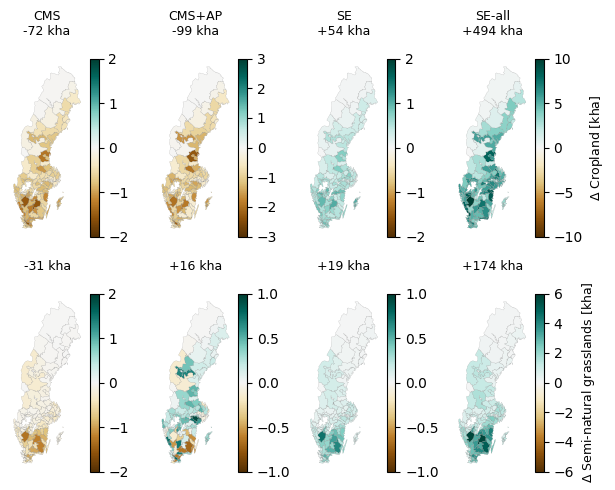

In [25]:
d = (
    session.get_attr('c','area',{'crop':'land_use', 'region':None})
    .drop('greenhouse', axis=1)
    .pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))
    .droplevel('scn')
) / 1_000

scns = ['2120','2121','2220','2320']

fig, axs = plt.subplots(2,len(scns), figsize=(1.6*len(scns),5))#, gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.1,)})
for i, lu in enumerate(d.columns.unique('land_use')):
    for j, scn in enumerate(scns): 
        ax = axs[i,j]
        map_data = d.loc[scn,lu]
        lim = np.ceil(map_data.abs().max().max())
        cm.plot.map_from_series(
            map_data,
            ax=ax,
            vmin = -lim,
            vmax = lim,
            **map_style1
        )
        ax.axis('off')
        title_str = ''
        if i == 0:
            title_str += scn_tuple(scn)[1] + '\n'
        title_str += f'{map_data.sum():+.0f} kha'
        ax.set_title(title_str, size=9)
        
        if scn == scns[-1]:
            cbar = ax.get_figure().axes[-1]
            cbar.set_ylabel(f'$\Delta$ {lu.capitalize()} [kha]', fontsize=9)
        

plt.tight_layout()
plt.show()

## Different crops

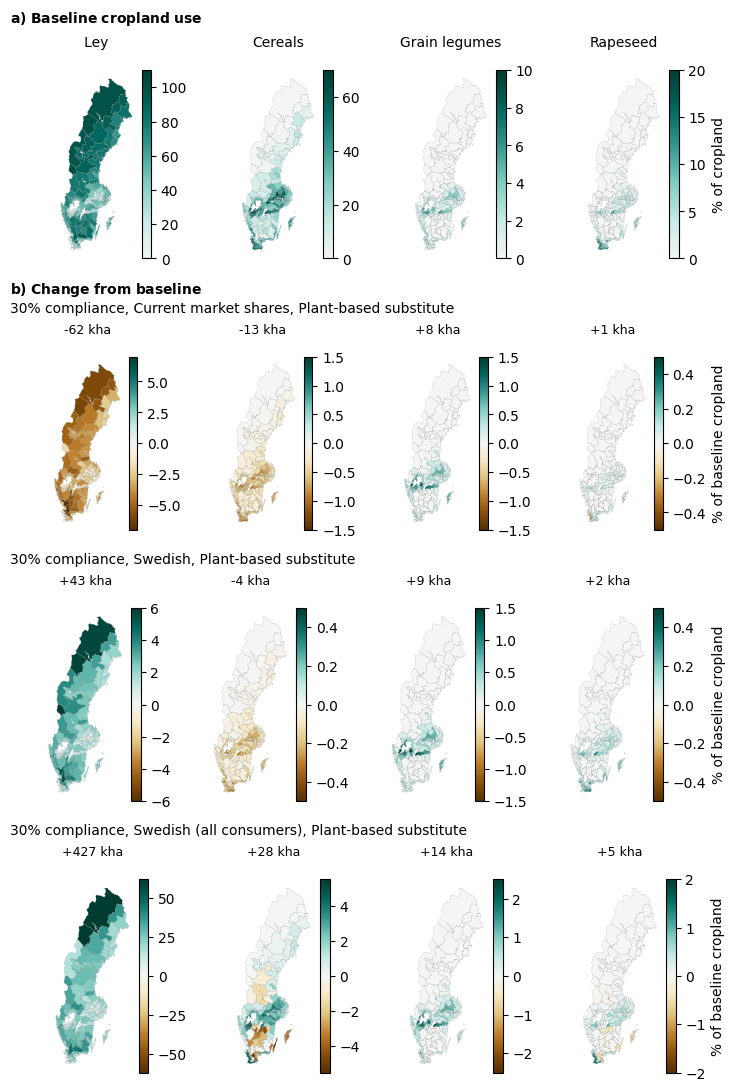

In [26]:
scns = ['2120','2220','2320']
scn_titles = {0 : r'$\bf{a)}$ $\bf{Baseline}$ $\bf{cropland}$ $\bf{use}$'}

for i, scn in enumerate(scns):
    if i == 0:
        title_str = r'$\bf{b)}$ $\bf{Change}$ $\bf{from}$ $\bf{baseline}$'+'\n'
    else:
        title_str = ''
    tpl = scn_tuple(scn, long=True)
    title_str += f'{tpl[0]} compliance, {tpl[1]}, {tpl[2]} substitute'.replace("\n","")
    scn_titles.update(
        {i+1:title_str}
    )

plot_data = (
    session.get_attr('C', 'area', {'crop':['land_use','crop_group'], 'region':None})
    .loc['SLV','cropland']
    .T
    .rename({'Cereals, winter':'Cereals', 'Cereals, spring':'Cereals'})
    .groupby(['crop_group','region'])
    .sum()
)

plot_data1_nat = plot_data.groupby('crop_group').sum()/1000
plot_data1 = plot_data.div(plot_data.groupby('region').sum()[BL_SCN[1]], axis=0) * 100

plot_data2 = plot_data1.sub(plot_data1[BL_SCN[1]], axis=0)
plot_data2_nat = plot_data1_nat.sub(plot_data1_nat[BL_SCN[1]], axis=0)

crps = ['Ley','Cereals','Grain legumes','Brassicaceae']

h = 2.7
w = 1.8
fig = plt.figure(constrained_layout=True, figsize=(w*len(crps), h+h*len(scns)))
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(scns)+1, ncols=1)
for row, subfig in enumerate(subfigs):
    
    axs = subfig.subplots(nrows=1, ncols=len(crps))
    subfig.suptitle(scn_titles[row], x=0, ha='left', size=10)
    if row==0:
        for crp, ax in zip(crps,axs):
            map_data = plot_data1['0'].loc[crp]
            lim = np.ceil(map_data.max()/10)*10
            leg_str = '% of cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=0, vmax=lim, **map_style2, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            ax.set_title('Rapeseed' if crp == 'Brassicaceae' else '   Ley   ' if crp=='Ley' else crp, size=10)
        
    else:
        scn = scns[row-1]
        for crp, ax in zip(crps,axs):
            map_data = plot_data2[scn].loc[crp]
            # lim = np.ceil(abs(plot_data2[scns].loc[crp]).quantile(0.99).max())
            lim = np.ceil(abs(map_data).quantile(0.99).max()*2)/2
            leg_str = '% of baseline cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=-lim, vmax=lim, **map_style1, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            nat_chg = plot_data2_nat[scn][crp]
            ax.set_title(f'{nat_chg:+.0f} kha', size=9)

# plt.savefig('map_cropland.png')
plt.show()

# Use of cereals

In [27]:
d = (
    session.get_attr('c','production_per_use',{'crop':'crop_group2','demand':None})
    .loc[:,'Cereals']
    .rename(columns=lambda x: 'feed' if 'feed' in x else x)
    .T.groupby('demand').sum().T
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d.set_index(make_scn_idx(d.index), inplace=True)
d['food+export'] = d['food'] + d['export']

# TEST SAFAD

In [ ]:
if False:
    codes = pd.read_csv('SAFAD_data/SAFAD IP Recipes.csv')['Food code'].unique()
    len(codes)
    
    for c in codes:
        try:
            print(c,end=': ')
            print(round(
                SAFAD.get_footprints(c)['Carbon footprint, primary production'] /
                SAFAD.get_GHG(c, CO2eq='GWP100 AR6').drop('Transport', level='process').sum(),
                2
            ))
        except:
            print('Failed')